In [1]:
# Magic commands
%matplotlib inline
%matplotlib notebook

# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from qutip import *
from pylab import *
from ipywidgets import widgets
from IPython.display import display, HTML

# Spectrum analysis
To take a look at the level shifts of the system, we can make use of a faster method than rigorously scanning a frequency range, namely spectrum analysis. The emission/absorption spectrum of for example the qubit can be obtained by taking the Fourier transform of the single-time correlation function:

\begin{equation}
    S_q(\omega) = \int_{-\infty}^{+\infty} \left< \hat{a}(t) \hat{a}^\dagger(0) \right> e^{i\omega t} dt
\end{equation}

For this, some parameters and objects need to be redefined, depending on the situation, which is done in the first cell below. Note that the decay rate must be nonzero to calculate the spectrum.

Alternatively, if one is only interested in the transition between the ground and 1st excited states (fundamental transition),
one can replace the field operators with $|e><g|$ and $|g><e|$.

The returned spectrum contains nonzero values for negative frequencies. The difference between positive and negative frequencies has a nice interpretation, namely that the negative ones correspond to the emission spectrum, and the positive frequencies to the absorption spectrum.

# Notice
the range and the resolution of the spectrum are determined by $t_{step}$ and $t_{max}$.


### Kerr oscillator (Transmon qubit with the rotating wave approximation)

#### Hamiltonian argument : 
$\omega_q$ : Fundamental frequency of the Kerr oscillator.\
$\omega_d$ : Frequency of the driving field. \
$E_c$      : Nonlinearilty of the Kerr oscillator. At the same time, this is an anharmonicity in this case.

In [2]:
def cos(t,H_args):
    return H_args['amp']*np.cos(H_args['wd']*t+H_args['phase'])

In [3]:
Nq = 10
a = tensor(destroy(Nq))
nq = a.dag()*a
H_args = {'wq' : 6.5, 'Ec': 0.2, 'wd': 4.0 ,'type' : 'Kerr'}
H_args['qubit_linewidth'] = 10e-3    #GHz. Without 2pi.
wq = 2*pi*H_args['wq']
Ec = 2*pi*H_args['Ec']
wd = 2*pi*H_args['wd']
H_args['nth'] = 0.0
H_args['wdco'] = wd - wq
H_args['wdcr'] = wd + wq
c_ops = [sqrt(2*pi*H_args['qubit_linewidth']*(H_args['nth']+1))*a,sqrt(2*pi*H_args['qubit_linewidth']*(H_args['nth']))*a.dag()]  # collapse operator(s)


Hq = nq*(wq)- Ec/2*a.dag()*a.dag()*a*a   # Qubit rotating frame.

<IPython.core.display.Javascript object>


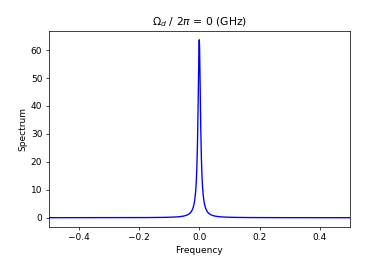

frequency shift : 0.0 MHz


<IPython.core.display.Javascript object>


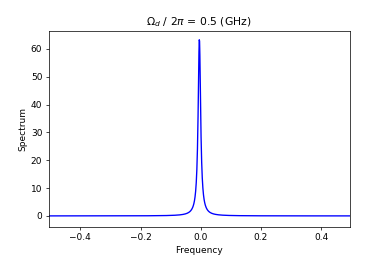

frequency shift : 4.999949999999999 MHz


In [4]:
psi0 = tensor(basis(Nq, 0))   # initial state

t_max = 1000
t_step = t_max/100000

# ket_2 = basis(Nq, 2)    # 1st excited state.
ket_1 = basis(Nq, 1)    # 1st excited state.
ket_0 = basis(Nq, 0)    # Ground state.

# up = ket_1*ket_0.dag()
# down = ket_0*ket_1.dag()
# up2 = ket_2*ket_1.dag()
# down2 = ket_1*ket_2.dag()

tlist  = np.linspace(0, t_max, int(t_max/t_step))        # unit : ns, time values for which to evaluate the correlation function
tlist0 = np.linspace(0, t_max, 10001)                    # unit : ns, time values for which to evaluate the correlation function
amplist = [0,0.5]                                        # unit : 2pi * GHz, external driving strength. 
for i in range(len(amplist)):
    plt.figure()
    H_args['phase'] = 2*pi*0.0
    H_args['amp'] =   2*pi*amplist[i]
    H = [Hq, [a, Ex_co_pos], [a.dag(), Ex_co_neg], [a, Ex_cr_neg], [a.dag(), Ex_cr_pos]]
    output = mesolve(H, psi0, tlist0, c_ops, args = H_args)
    psi0 = output.states[-1]
    
    corr = correlation_2op_1t(H, psi0, tlist, c_ops, a, a.dag(), solver = "me",  args = H_args) # evaluate correlation function
    wlist, spec = spectrum_correlation_fft(tlist, corr,inverse=True)                            # calculate spectrum
    wlist = wlist
    Max = wlist[spec.tolist().index(max(spec))]
    print('frequency shift : {} MHz'.format(1e3*(((wq-wq)-Max)/2/pi)))

    plt.plot(wlist / (2*pi), spec, 'b-')
    plt.xlim([-0.5+Max/2/pi, 0.5+Max/2/pi])
    plt.xlabel('Frequency')
    plt.ylabel('Spectrum')
    plt.title(r'$\Omega_{d}~/~2\pi$ = %s (GHz)'%amplist[i])

In [ ]:
## save fitting results

savedata = {'H_arg' : H_arg, 'transmission_data' : ydata, 'transmission_fit' : result_leastsq.best_fit, 'fitting_result' : result_leastsq.fit_report()}
outfile = open('.dat', 'wb')
pickle.dump(savedata, outfile)
outfile.close()

In [ ]:
## load fitting results

load_file = open('TMS_12dBm.dat', 'rb')
loaddata = pickle.load(load_file)

plt.figure()
plt.plot(loaddata['probe_freq'], loaddata['transmission_data'], 'bo', alpha=0.5)
plt.plot(loaddata['probe_freq'], loaddata['transmission_fit'], 'r-', alpha=1)
plt.legend()
plt.show()

print(loaddata['fitting_result'])

<IPython.core.display.Javascript object>


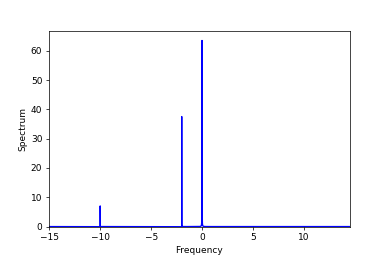

Text(0, 0.5, 'Spectrum')

In [18]:
plt.figure()
plt.plot(wlist / (2*pi), spec, 'b-')
# plt.xlim([-0.5+Max/2/pi, 0.5+Max/2/pi])
plt.ylim([0, 70])
# plt.xlim([-0.9, 0])
plt.xlabel('Frequency')
plt.ylabel('Spectrum')

<IPython.core.display.Javascript object>


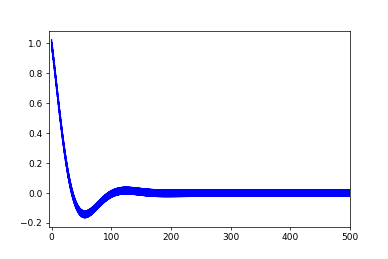

(-5, 500)

In [19]:
plt.figure()
# plt.plot(tlist[10000:], corr[10000:], 'b-')
plt.plot(tlist, np.real(corr), 'b-')
plt.xlim(-5,500)

### Duffing oscillator (Transmon qubit without the rotating wave approximation)

#### Hamiltonian argument : 
$\omega_q$ : Fundamental frequency of the Kerr oscillator.\
$\omega_d$ : Frequency of the driving field. \
$E_c$      : Nonlinearilty of the Duffing oscillator.

In [152]:
def cos(t,H_args):
    return H_args['amp']*np.cos(H_args['wd']*t+H_args['phase'])
def Ex_co_neg(t,H_args):
    return H_args['amp']/2*np.exp(-1j*H_args['wdco']*t+H_args['phase'])
def Ex_co_pos(t,H_args):
    return H_args['amp']/2*np.exp(1j*H_args['wdco']*t+H_args['phase'])
def Ex_cr_neg(t,H_args):
    return H_args['amp']/2*np.exp(-1j*H_args['wdcr']*t+H_args['phase'])
def Ex_cr_pos(t,H_args):
    return H_args['amp']/2*np.exp(1j*H_args['wdcr']*t+H_args['phase'])

In [ ]:
Nq = 10
a = tensor(destroy(Nq))
nq = a.dag()*a
H_args = {'wq' : 6.0, 'Ec': 0.2, 'wd': 4.0 }
H_args['qubit_linewidth'] = 10e-3    #GHz. Without 2pi.
wq = 2*pi*H_args['wq']
Ec = 2*pi*H_args['Ec']
wd = 2*pi*H_args['wd']
H_args['nth'] = 0.2
H_args['wdco'] = wd - wq
H_args['wdcr'] = wd + wq
c_ops = [sqrt(2*pi*H_args['qubit_linewidth']*(H_args['nth']+1))*a,sqrt(2*pi*H_args['qubit_linewidth']*(H_args['nth']))*a.dag()]  # collapse operator(s)
Hq = - Ec/2*a.dag()*a.dag()*a*a   # Qubit rotating frame.

In [ ]:
psi0 = tensor(basis(Nq, 0))   # initial state

t_max = 1000
t_step = t_max/100000

num_cyl = 1/H_args['wd']/t_step

ket_2 = basis(Nq, 2)    # 1st excited state.
ket_1 = basis(Nq, 1)    # 1st excited state.
ket_0 = basis(Nq, 0)    # Ground state.

up = ket_1*ket_0.dag()
down = ket_0*ket_1.dag()
up2 = ket_2*ket_1.dag()
down2 = ket_1*ket_2.dag()

tlist  = np.linspace(0, t_max, int(t_max/t_step))    # unit : ns, time values for which to evaluate the correlation function
tlist0 = np.linspace(0, t_max, 1001)                    # unit : ns, time values for which to evaluate the correlation function
amplist = [1.5]                                        # unit : 2pi * GHz, external driving strength. 
for i in range(len(amplist)):
    plt.figure()
    H_args['phase'] = 2*pi*0.0
    H_args['amp'] =   2*pi*amplist[i]
    H = [Hq, [a, Ex_co_pos], [a.dag(), Ex_co_neg], [a, Ex_co_neg], [a.dag(), Ex_co_pos]]
    output = mesolve(Hq, psi0, tlist0, c_ops, args = H_args)
    psi0 = output.states[-1]
    
    corr = correlation_2op_1t(H, psi0, tlist, c_ops, a, a.dag(), solver = "me",  args = H_args) # evaluate correlation function

    wlist, spec = spectrum_correlation_fft(tlist, corr,inverse=True)                       # calculate spectrum
    wlist = wlist
    Max = wlist[spec.tolist().index(max(spec))]
    print('frequency shift : {} MHz'.format(1e3*(-Max/2/pi)))

    plt.plot(wlist / (2*pi), spec, 'b-')
    plt.xlim([-0.5+Max/2/pi, 0.5+Max/2/pi])
    plt.xlabel('Frequency')
    plt.ylabel('Spectrum')
    plt.title(r'$\Omega_{d}~/~2\pi$ = %s (GHz)'%amplist[i])